In [1]:
# %% [markdown]
# # Random Forest Regression for Train Delay Prediction with 'info' Encoding

# %%
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../DBtrainrides_complete_preprocessed_2.csv')

In [3]:
df.head()

,ID_Base,ID_Timestamp,stop_number,IBNR,long,lat,arrival_plan,departure_plan,arrival_delay_m,transformed_info_message,prev_arrival_delay_m,prev_departure_delay_m,weighted_avg_prev_delay,max_station_number,station_progress,info_label_encoded,arrival_normalized,departure_normalized
0,-1001326572688500578,2407082041,2,8011118.0,13.375988,52.509379,2024-07-08 20:44:00,2024-07-08 20:45:00,0.0,No message,0.0,0.0,0.000000,7,0.285714,0,0.125866,0.125965
1,-1001326572688500578,2407082041,3,8011160.0,9.095851,48.849792,2024-07-08 20:50:00,2024-07-08 20:50:00,0.0,No message,0.0,0.0,0.000000,7,0.428571,0,0.126460,0.126460
2,-1001326572688500578,2407082041,4,8011167.0,13.299437,52.530276,2024-07-08 20:55:00,2024-07-08 20:56:00,0.0,No message,0.0,0.0,0.000000,7,0.571429,0,0.126954,0.127053
3,-1001326572688500578,2407082041,5,8010404.0,13.196898,52.534648,2024-07-08 21:00:00,2024-07-08 21:03:00,2.0,No message,0.0,0.0,0.000000,7,0.714286,0,0.127449,0.127746
4,-1001326572688500578,2407082041,6,8080040.0,13.128917,52.549396,2024-07-08 21:06:00,2024-07-08 21:07:00,1.0,No message,2.0,0.0,0.666667,7,0.857143,0,0.128043,0.128142


In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../utils')))  # Add the parent directory to the path

from utils import custom_train_test_split, ordinal_scaling, normalize_dates


Data Types:
ID_Base                       int64
ID_Timestamp                  int64
stop_number                   int64
IBNR                        float64
long                        float64
lat                         float64
arrival_plan                 object
departure_plan               object
prev_arrival_delay_m        float64
prev_departure_delay_m      float64
weighted_avg_prev_delay     float64
max_station_number            int64
station_progress            float64
transformed_info_message     object
arrival_normalized          float64
departure_normalized        float64
arrival_delay_m             float64
dtype: object

Training Data Shape: (1531112, 13)
Testing Data Shape: (383004, 13)

Random Forest Model Performance on Test Set:
Mean Squared Error (MSE): 3.41
Root Mean Squared Error (RMSE): 1.85
Mean Absolute Error (MAE): 0.62
R-squared (R2): 0.67


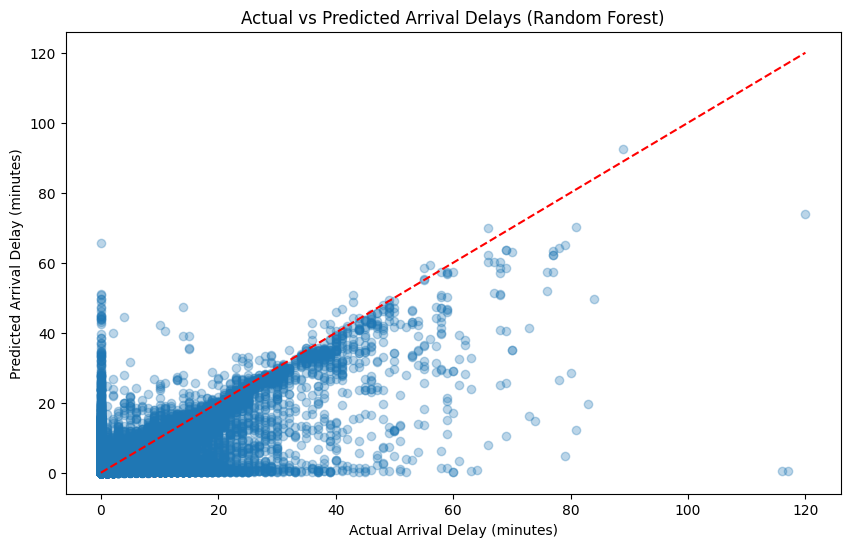


Top 15 Important Features:
                    Feature  Importance
7    prev_departure_delay_m    0.730883
8   weighted_avg_prev_delay    0.158910
5                       lat    0.028302
3                      IBNR    0.022422
6      prev_arrival_delay_m    0.015984
4                      long    0.015577
10         station_progress    0.006724
9        max_station_number    0.005565
2               stop_number    0.004996
0                   ID_Base    0.003593
11       arrival_normalized    0.003069
12     departure_normalized    0.002924
1              ID_Timestamp    0.001053


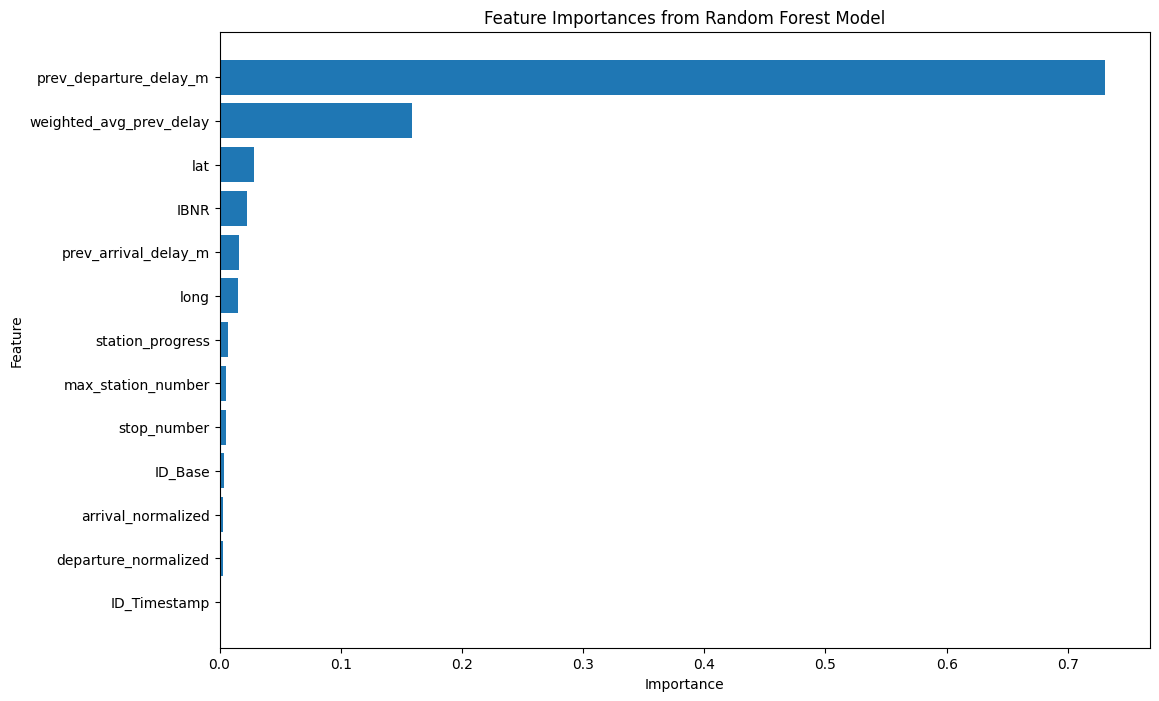

In [5]:

# %%
# List of features to include
feature_columns = [
    'ID_Base',
    'ID_Timestamp',
    'stop_number',
    'IBNR',
    'long',
    'lat',
    'arrival_plan',
    'departure_plan',
    'prev_arrival_delay_m',
    'prev_departure_delay_m',
    'weighted_avg_prev_delay',
    'max_station_number',
    'station_progress',
    'transformed_info_message',  # Include for encoding
    'arrival_normalized',
    'departure_normalized'
]

# Target variable
target_column = 'arrival_delay_m'  # Predicting arrival delay in minutes

# Create a new DataFrame with the selected features and target
data = df[feature_columns + [target_column]].copy()

# Display data types
print("\nData Types:")
print(data.dtypes)

# %% [markdown]
# ## Data Preprocessing

# %%
# Handle missing values
# Drop rows with missing target values
data = data.dropna(subset=[target_column])

# Convert numerical features to numeric data types and handle missing values
numerical_features = [
    'stop_number',
    'long',
    'lat',
    'prev_arrival_delay_m',
    'prev_departure_delay_m',
    'weighted_avg_prev_delay',
    'max_station_number',
    'station_progress',
    'arrival_normalized',
    'departure_normalized'
]

# Convert to numeric and handle missing values
data[numerical_features] = data[numerical_features].apply(pd.to_numeric, errors='coerce')
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median())

# Convert categorical features to string type
categorical_features = ['IBNR']

for col in categorical_features:
    data[col] = data[col].astype(str)

# %% [markdown]
# ### Process Datetime Features

# %%
def extract_datetime_features(df, datetime_column):
    df[datetime_column] = pd.to_datetime(df[datetime_column], errors='coerce')
    df[datetime_column + '_hour'] = df[datetime_column].dt.hour
    df[datetime_column + '_minute'] = df[datetime_column].dt.minute
    df[datetime_column + '_dayofweek'] = df[datetime_column].dt.dayofweek
    df[datetime_column + '_day'] = df[datetime_column].dt.day
    # Drop the original datetime column
    df.drop(columns=[datetime_column], inplace=True)
    return df

# data = extract_datetime_features(data, 'arrival_plan')
# data = extract_datetime_features(data, 'departure_plan')

# # Update numerical features list with new datetime features
# datetime_features = [
#     'arrival_plan_hour',
#     'arrival_plan_minute',
#     'arrival_plan_dayofweek',
#     'arrival_plan_day',
#     'departure_plan_hour',
#     'departure_plan_minute',
#     'departure_plan_dayofweek',
#     'departure_plan_day'
# ]

# numerical_features.extend(datetime_features)

# %% [markdown]
# ## Split Data into Training and Testing Sets

# %%
# Define X and y
X = data.drop(columns=[target_column])
y = data[target_column]

# Split the data (Ensure 'transformed_info_message' is included in X)
X_train, y_train, X_test, y_test = custom_train_test_split(data, "arrival_delay_m", 0.8)

print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# %% [markdown]
# ## Train the Ensemble Model (Random Forest Regressor)

# %%
# Initialize the Random Forest Regressor with hyperparameters
ensemble_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=15,           # Maximum depth of the tree
    min_samples_split=50,   # Minimum number of samples required to split an internal node
    random_state=42,
    n_jobs=-1               # Use all available cores
)

# Train the model on the training set
ensemble_model.fit(X_train, y_train)

# %% [markdown]
# ## Make Predictions and Evaluate the Model

# %%
# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# %% [markdown]
# ### Plot Predicted vs Actual Values

# %%
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Arrival Delay (minutes)')
plt.ylabel('Predicted Arrival Delay (minutes)')
plt.title('Actual vs Predicted Arrival Delays (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# %% [markdown]
# ## Feature Importance

# %%
# Get feature importances from the model
feature_importances = ensemble_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
fi_df = fi_df.sort_values('Importance', ascending=False)

# Display the top 15 features
print("\nTop 15 Important Features:")
print(fi_df.head(15))

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Define Germany's geographic boundaries (approximate)
germany_bounds = {
    'min_lat': 47.0, 'max_lat': 55.0,  # Latitude range
    'min_lon': 5.0, 'max_lon': 15.0    # Longitude range
}

# Create a grid over Germany
def create_grid(bounds, cell_size):
    lat_edges = np.arange(bounds['min_lat'], bounds['max_lat'], cell_size)
    lon_edges = np.arange(bounds['min_lon'], bounds['max_lon'], cell_size)
    return lat_edges, lon_edges

# Define cell size (in degrees)
cell_size = 0.25  # Adjust for desired resolution (smaller = finer grid)

lat_edges, lon_edges = create_grid(germany_bounds, cell_size)

# Assign test data points to grid cells
# Assuming X_test has 'latitude' and 'longitude' columns
X_test['lat_bin'] = pd.cut(X_test['lat'], bins=lat_edges)
X_test['lon_bin'] = pd.cut(X_test['long'], bins=lon_edges)

# Combine with y_test and y_pred
data = pd.DataFrame({
    'lat_bin': X_test['lat_bin'],
    'lon_bin': X_test['lon_bin'],
    'y_test': y_test,
    'y_pred': y_pred
})

# Compute squared error
data['squared_error'] = (data['y_test'] - data['y_pred'])**2

# Group by grid cells and compute MSE
spatial_mse = data.groupby(['lat_bin', 'lon_bin'])['squared_error'].mean().reset_index()
spatial_mse.rename(columns={'squared_error': 'spatial_mse'}, inplace=True)

# Add grid cell centers for visualization
spatial_mse['lat_center'] = spatial_mse['lat_bin'].apply(lambda x: x.mid)
spatial_mse['lon_center'] = spatial_mse['lon_bin'].apply(lambda x: x.mid)

/tmp/ipykernel_50487/892944642.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_mse = data.groupby(['lat_bin', 'lon_bin'])['squared_error'].mean().reset_index()


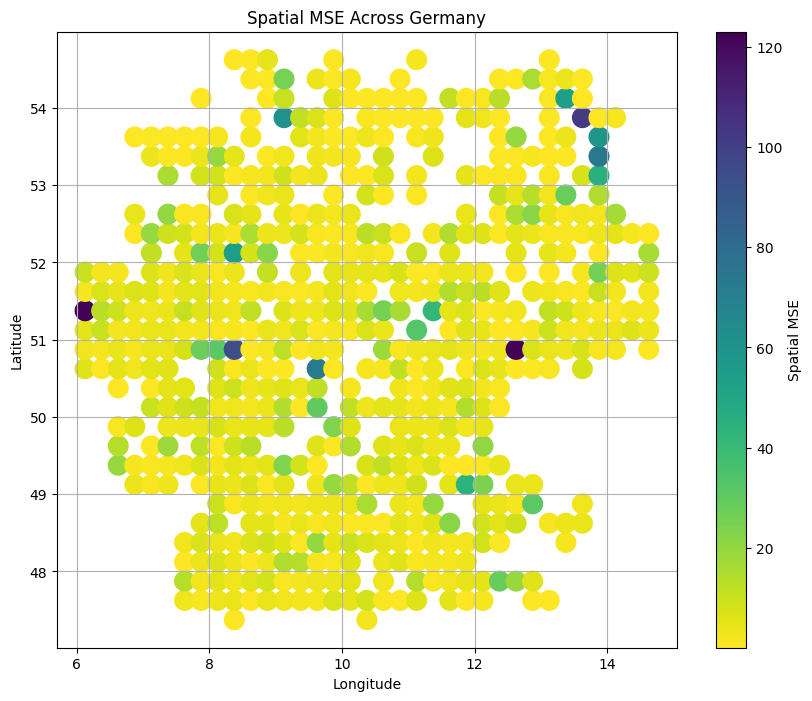

In [7]:
plt.figure(figsize=(10, 8))
plt.scatter(spatial_mse['lon_center'], spatial_mse['lat_center'], c=spatial_mse['spatial_mse'], cmap='viridis_r', s=200)
plt.colorbar(label='Spatial MSE')
plt.title('Spatial MSE Across Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [8]:
overall_spatial_mse = spatial_mse['spatial_mse'].mean()
overall_spatial_mse

np.float64(6.453804381525344)